# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, to_date
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StringType
from pyspark.sql.types import DateType


import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify_project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#load data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## ** The Problem & Definition of Churn **

We are running a music app company. We have users who are using our service. Some users churns(stops using our service).
In this work we will try to predict the most risky users who are tend to churn. After we find the risky population we can offer them discount or something else. 
Let's start by exploring and preparing our data!

Note: Churn for us means cancelling the service. In the data, we can see it at "page" column, which has value as "Cancellation Confirmation".

Methods: Because we have labeled data, we will use supervised machine learning algorithms. We will try to predict that whether the user will churn or not. So it is a classification problem. We will find the most effective features which is related to churn. To find them we will run machine learning classification algorithms. We will use algorithms like Logistic Regression, Gradient Boosted Trees and RandomForest to see which gives best result.
The number of churned users are very small. So I will use f1 score as main metric.

In [4]:
# create table data
user_log.createOrReplaceTempView("user_log_table")

In [5]:
# looking for a sample data.
#user_log.take(5)
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [7]:
#checking row count, column names and types
print(user_log.count())

user_log.printSchema()

286500
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#checking duplicated rows
user_log.dropDuplicates()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## Create Some Functions

In [9]:
def check_unique_values_of_column(df, col_name):
    '''
    inputs: df: the dataframe to check unique values of it.
            col_name: the column where to look.
            
    outputs:df_asc: the first 10 values of column in ascending order
            df_desc: the first 10 values of column in descending order
    '''
    df_asc = df.select(col_name).dropDuplicates().sort(col_name).show(10,False)
    df_desc = df.select(col_name).dropDuplicates().sort(desc(col_name)).show(10,False)
    return df_asc, df_desc

In [10]:
def look_for_specific_value_of_column(df,col,val):
    '''
        inputs: df: the dataframe to get value.
                col: the column of dataframe to look.
                val: the value of column to search.
        output: the first 5 rows of dataframe with condition.
    '''
    if val == "null":
        return df.select(["artist", "userId", "sessionId", "firstname", "page", "song"]).where(df[col].isNull()).take(5)
    else:
        return df.select(["artist", "userId", "sessionId", "firstname", "page", "song"]).where(df[col] == val).take(5)

In [11]:
def get_user_counts_of_categorical_column(tbl,col) :
    '''
        tbl: name of table to look.
        col: name of column to look.
        this function returns user counts of the categorical column.
    '''
    return spark.sql('''
          SELECT '''+col+''', count(distinct userId)
          FROM '''+tbl+ '''  
          group by '''+ col
          ).show()

In [12]:
def get_count_of_null_value_of_column(tbl,col):
    '''
        tbl: name of table to look.
        col: name of column to look.
        this function gets counts of null value of the column.
    '''
    spark.sql('''
          SELECT count(DISTINCT userId), count(userId)
          FROM '''+ tbl+'''  
          where ''' +col+ ''' is null'''
          ).show()

In [13]:
def get_count_of_categorical_column(tbl,col):
    '''
        tbl: name of table to look.
        col: name of column to look.
        this function gets distinct count of the categorical column.
    '''
    spark.sql('''
          SELECT count(distinct ''' + col + ''' ) 
          FROM ''' + tbl
          ).show()

## Check UserId Column

In [14]:
check_unique_values_of_column(user_log, "userId")

+------+
|userId|
+------+
|      |
|10    |
|100   |
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows

+------+
|userId|
+------+
|99    |
|98    |
|97    |
|96    |
|95    |
|94    |
|93    |
|92    |
|91    |
|90    |
+------+
only showing top 10 rows



(None, None)

In [15]:
get_count_of_null_value_of_column("user_log_table", "userId")

+----------------------+-------------+
|count(DISTINCT userId)|count(userId)|
+----------------------+-------------+
|                     0|            0|
+----------------------+-------------+



In [16]:
#check user with id of ""
spark.sql('''
          SELECT count(DISTINCT userId), count(userId)
          FROM user_log_table
          where userId = ""'''
          ).show()

+----------------------+-------------+
|count(DISTINCT userId)|count(userId)|
+----------------------+-------------+
|                     1|         8346|
+----------------------+-------------+



In [17]:
look_for_specific_value_of_column(user_log,"userId","")

[Row(artist=None, userId='', sessionId=8, firstname=None, page='Home', song=None),
 Row(artist=None, userId='', sessionId=8, firstname=None, page='Help', song=None),
 Row(artist=None, userId='', sessionId=8, firstname=None, page='Home', song=None),
 Row(artist=None, userId='', sessionId=8, firstname=None, page='Login', song=None),
 Row(artist=None, userId='', sessionId=240, firstname=None, page='Home', song=None)]

## Drop Empty UserId Rows

In [18]:
# check the name of users with userId= ""
spark.sql('''
          SELECT distinct firstName, lastName
          FROM user_log_table
          where userId = ""'''
          ).show()

+---------+--------+
|firstName|lastName|
+---------+--------+
|     null|    null|
+---------+--------+



In [19]:
# remove rows with userId=""
user_log = spark.sql('''
          SELECT *
          FROM user_log_table
          where userId <> ""'''
          )

In [20]:
user_log.count()

278154

## Create Table with New State of DataFrame

In [21]:
user_log.createOrReplaceTempView("user_log_table")

## Check Artist Column

In [22]:
check_unique_values_of_column(user_log, "artist")

+----------------------------+
|artist                      |
+----------------------------+
|null                        |
|!!!                         |
|& And Oceans                |
|'N Sync/Phil Collins        |
|'Til Tuesday                |
|'t Hof Van Commerce         |
|'t Hof Van Commerce & Brahim|
|(Love) Tattoo               |
|(hed) p.e.                  |
|*NSYNC featuring Nelly      |
+----------------------------+
only showing top 10 rows

+-----------------------+
|artist                 |
+-----------------------+
|ÃÂlafur Arnalds      |
|ÃÂon                 |
|ÃÂtienne Daho        |
|ÃÂngeles del Infierno|
|ÃÂµ-ziq               |
|zero dB                |
|zebrahead              |
|xbxrx                  |
|vanize                 |
|unloco                 |
+-----------------------+
only showing top 10 rows



(None, None)

In [23]:
get_count_of_null_value_of_column("user_log_table", "artist")

+----------------------+-------------+
|count(DISTINCT userId)|count(userId)|
+----------------------+-------------+
|                   224|        50046|
+----------------------+-------------+



In [24]:
look_for_specific_value_of_column(user_log, "artist", "null")

[Row(artist=None, userId='30', sessionId=29, firstname='Colin', page='Add to Playlist', song=None),
 Row(artist=None, userId='9', sessionId=8, firstname='Micah', page='Roll Advert', song=None),
 Row(artist=None, userId='9', sessionId=8, firstname='Micah', page='Thumbs Up', song=None),
 Row(artist=None, userId='54', sessionId=53, firstname='Alexi', page='Downgrade', song=None),
 Row(artist=None, userId='54', sessionId=53, firstname='Alexi', page='Thumbs Up', song=None)]

In [25]:
look_for_specific_value_of_column(user_log, "artist", "!!!")

[Row(artist='!!!', userId='95', sessionId=398, firstname='Faigy', page='NextSong', song='A New Name'),
 Row(artist='!!!', userId='121', sessionId=781, firstname='Nikolas', page='NextSong', song='Must Be The Moon'),
 Row(artist='!!!', userId='45', sessionId=1045, firstname='Isobella', page='NextSong', song='Yadnus'),
 Row(artist='!!!', userId='138', sessionId=1305, firstname='Samuel', page='NextSong', song='Must Be The Moon'),
 Row(artist='!!!', userId='28', sessionId=1519, firstname='Teagan', page='NextSong', song='Yadnus')]

In [26]:
user_log.filter(user_log.artist == "!!!").count()

10

In [27]:
get_count_of_categorical_column("user_log_table","artist")

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+



## Check Auth Column

In [28]:
asc_auth, desc_auth = check_unique_values_of_column(user_log, "auth")

+---------+
|auth     |
+---------+
|Cancelled|
|Logged In|
+---------+

+---------+
|auth     |
+---------+
|Logged In|
|Cancelled|
+---------+



In [29]:
# number of users with two state of auth.
spark.sql('''
            select count(distinct userId) from (
          SELECT userId, count(distinct auth)
          FROM user_log_table group by userId having  count(distinct auth) =2)  '''
          ).show(10)

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    52|
+----------------------+



In [30]:
# distinct pages for "cancelled" value of auth column.
spark.sql('''
          SELECT distinct page
          FROM user_log_table where auth= "Cancelled"  '''
          ).show(10)

+--------------------+
|                page|
+--------------------+
|Cancellation Conf...|
+--------------------+



## Check Gender

In [31]:
asc_gender, desc_gender = check_unique_values_of_column(user_log, "gender")

+------+
|gender|
+------+
|F     |
|M     |
+------+

+------+
|gender|
+------+
|M     |
|F     |
+------+



In [32]:
get_user_counts_of_categorical_column("user_log_table", "gender")

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



## Check itemInSession

In [33]:
check_unique_values_of_column(user_log,"itemInSession")

+-------------+
|itemInSession|
+-------------+
|0            |
|1            |
|2            |
|3            |
|4            |
|5            |
|6            |
|7            |
|8            |
|9            |
+-------------+
only showing top 10 rows

+-------------+
|itemInSession|
+-------------+
|1321         |
|1320         |
|1319         |
|1318         |
|1317         |
|1316         |
|1315         |
|1314         |
|1313         |
|1312         |
+-------------+
only showing top 10 rows



(None, None)

## Check Page

In [34]:
check_unique_values_of_column(user_log, "page")

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
+-------------------------+
only showing top 10 rows

+----------------+
|page            |
+----------------+
|Upgrade         |
|Thumbs Up       |
|Thumbs Down     |
|Submit Upgrade  |
|Submit Downgrade|
|Settings        |
|Save Settings   |
|Roll Advert     |
|NextSong        |
|Logout          |
+----------------+
only showing top 10 rows



(None, None)

In [35]:
get_count_of_categorical_column("user_log_table","page")

+--------------------+
|count(DISTINCT page)|
+--------------------+
|                  19|
+--------------------+



In [36]:
spark.sql('''
          SELECT page, count(distinct userId)
          FROM user_log_table where page in ("Downgrade","Upgrade") group by page  '''
          ).show(10)

+---------+----------------------+
|     page|count(DISTINCT userId)|
+---------+----------------------+
|Downgrade|                   154|
|  Upgrade|                   168|
+---------+----------------------+



In [37]:
# users with most downgrade counts 
spark.sql('''
          SELECT userId, count(*)
          FROM user_log_table where page in ("Submit Downgrade") group by userId order by 2 desc '''
          ).show(10)

+------+--------+
|userId|count(1)|
+------+--------+
|   140|       3|
|    39|       3|
|200003|       2|
|    61|       2|
|    20|       2|
|   131|       2|
|100004|       2|
|    35|       2|
|200023|       2|
|    85|       2|
+------+--------+
only showing top 10 rows



## Check Song

In [38]:
check_unique_values_of_column(user_log, "song")

+--------------------------------------------------------------+
|song                                                          |
+--------------------------------------------------------------+
|null                                                          |
|ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku                                |
| I Will Not Reap Destruction                                  |
|!@*$%#                                                        |
|#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version)|
|#1                                                            |
|#1 Fan [Feat. Keyshia Cole & J. Holiday] (Album Version)      |
|#1 Stunna                                                     |
|#16                                                           |
|#18 (Album Version)                                           |
+--------------------------------------------------------------+
only showing top 10 rows

+------------------------------------------------+
|song        

(None, None)

In [39]:
get_count_of_null_value_of_column("user_log_table", "song")

+----------------------+-------------+
|count(DISTINCT userId)|count(userId)|
+----------------------+-------------+
|                   224|        50046|
+----------------------+-------------+



In [40]:
look_for_specific_value_of_column(user_log,"song", "null")

[Row(artist=None, userId='30', sessionId=29, firstname='Colin', page='Add to Playlist', song=None),
 Row(artist=None, userId='9', sessionId=8, firstname='Micah', page='Roll Advert', song=None),
 Row(artist=None, userId='9', sessionId=8, firstname='Micah', page='Thumbs Up', song=None),
 Row(artist=None, userId='54', sessionId=53, firstname='Alexi', page='Downgrade', song=None),
 Row(artist=None, userId='54', sessionId=53, firstname='Alexi', page='Thumbs Up', song=None)]

In [41]:
get_count_of_categorical_column("user_log_table","song")

+--------------------+
|count(DISTINCT song)|
+--------------------+
|               58480|
+--------------------+



## Check sessionId

In [42]:
check_unique_values_of_column(user_log, "sessionId")

+---------+
|sessionId|
+---------+
|1        |
|2        |
|3        |
|4        |
|5        |
|6        |
|7        |
|8        |
|9        |
|10       |
+---------+
only showing top 10 rows

+---------+
|sessionId|
+---------+
|2474     |
|2464     |
|2459     |
|2446     |
|2444     |
|2441     |
|2434     |
|2433     |
|2432     |
|2431     |
+---------+
only showing top 10 rows



(None, None)

## Check Method

In [43]:
#get put
check_unique_values_of_column(user_log, "method")

+------+
|method|
+------+
|GET   |
|PUT   |
+------+

+------+
|method|
+------+
|PUT   |
|GET   |
+------+



(None, None)

## Check Registration

In [44]:
check_unique_values_of_column(user_log, "registration")

+-------------+
|registration |
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
+-------------+
only showing top 10 rows

+-------------+
|registration |
+-------------+
|1543247354000|
|1541370470000|
|1541268021000|
|1541223737000|
|1540940608000|
|1538336771000|
|1538333829000|
|1538331630000|
|1538316317000|
|1538313468000|
+-------------+
only showing top 10 rows



(None, None)

## Check Level

In [45]:
#free paid
check_unique_values_of_column(user_log, "level")

+-----+
|level|
+-----+
|free |
|paid |
+-----+

+-----+
|level|
+-----+
|paid |
|free |
+-----+



(None, None)

In [ ]:
get_count_of_categorical_column(user_log)

In [46]:
# count of users who expreienced free and paid versions (upgrade/downgrade)
spark.sql('''
            select count(distinct userId) from (
          SELECT userId, count(distinct level)
          FROM user_log_table group by userId having  count(distinct level) =2)  '''
          ).show(10)

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   135|
+----------------------+



## Check Location

In [47]:
check_unique_values_of_column(user_log, "location")

+---------------------------------+
|location                         |
+---------------------------------+
|Albany, OR                       |
|Albany-Schenectady-Troy, NY      |
|Alexandria, LA                   |
|Allentown-Bethlehem-Easton, PA-NJ|
|Anchorage, AK                    |
|Atlanta-Sandy Springs-Roswell, GA|
|Atlantic City-Hammonton, NJ      |
|Austin-Round Rock, TX            |
|Bakersfield, CA                  |
|Baltimore-Columbia-Towson, MD    |
+---------------------------------+
only showing top 10 rows

+--------------------------------------------+
|location                                    |
+--------------------------------------------+
|Winston-Salem, NC                           |
|Wilson, NC                                  |
|Washington-Arlington-Alexandria, DC-VA-MD-WV|
|Virginia Beach-Norfolk-Newport News, VA-NC  |
|Vineland-Bridgeton, NJ                      |
|Truckee-Grass Valley, CA                    |
|Troy, AL                                    |


(None, None)

## Check Status

In [48]:
check_unique_values_of_column(user_log, "status")

+------+
|status|
+------+
|200   |
|307   |
|404   |
+------+

+------+
|status|
+------+
|404   |
|307   |
|200   |
+------+



(None, None)

## Check UserAgent

In [49]:
check_unique_values_of_column(user_log, "userAgent")

+--------------------------------------------------------------------------------------------------------------------------+
|userAgent                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3"        |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.8 (KHTML, like Gecko) Version/8.0 Safari/600.1.8"        |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/6.1.5 Safari/537.77.4"   |


(None, None)

In [50]:
get_count_of_categorical_column("user_log_table","userAgent")

+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       56|
+-------------------------+



## Check Length

In [51]:
#has null
check_unique_values_of_column(user_log, "length")

+--------+
|length  |
+--------+
|null    |
|0.78322 |
|2.16771 |
|4.04853 |
|4.8322  |
|6.3473  |
|7.83628 |
|8.30649 |
|9.01179 |
|10.03057|
+--------+
only showing top 10 rows

+----------+
|length    |
+----------+
|3024.66567|
|2743.09179|
|2732.2771 |
|2594.87302|
|2560.7571 |
|2520.99873|
|2390.20363|
|2369.04444|
|2310.79138|
|2297.39057|
+----------+
only showing top 10 rows



(None, None)

In [52]:
get_count_of_null_value_of_column("user_log_table", "length")

+----------------------+-------------+
|count(DISTINCT userId)|count(userId)|
+----------------------+-------------+
|                   224|        50046|
+----------------------+-------------+



## Check ts

In [53]:
check_unique_values_of_column(user_log, "ts")

+-------------+
|ts           |
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
+-------------+
only showing top 10 rows

+-------------+
|ts           |
+-------------+
|1543799476000|
|1543622579000|
|1543622432000|
|1543622411000|
|1543622398000|
|1543622395000|
|1543622365000|
|1543622355000|
|1543622320000|
|1543622287000|
+-------------+
only showing top 10 rows



(None, None)

## Add Date Attributes (year, month, day, hour)

In [54]:
#defining function which converts column to hour
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)

In [55]:
#defining function which converts column to hour
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)

In [56]:
#defining function which converts column to hour
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)

In [57]:
#defining function which converts column to hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [58]:
# creating hour column applying by get_hour function on the ts column
user_log = user_log.withColumn("hourr", get_hour(user_log.ts))

In [59]:
# creating hour column applying by get_day function on the ts column
user_log = user_log.withColumn("dayy", get_day(user_log.ts))

In [60]:
# creating hour column applying by get_month function on the ts column
user_log = user_log.withColumn("monthh", get_month(user_log.ts))

In [61]:
# creating hour column applying by get_year function on the ts column
user_log = user_log.withColumn("yearr", get_year(user_log.ts))

In [62]:
user_log.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hourr='0', dayy='1', monthh='10', yearr='2018'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', hourr='0', dayy='1', monthh='10', yearr='2018')]

## Create Table with New Columns

In [78]:
user_log.createOrReplaceTempView("user_log_table")

In [79]:
#check hourr column
spark.sql('''
          SELECT distinct hourr
          FROM user_log_table '''
          ).show(30)

+-----+
|hourr|
+-----+
|    7|
|   15|
|   11|
|    3|
|    8|
|   22|
|   16|
|    0|
|    5|
|   18|
|   17|
|    6|
|   19|
|   23|
|    9|
|    1|
|   20|
|   10|
|    4|
|   12|
|   13|
|   14|
|   21|
|    2|
+-----+



In [80]:
#check dayy column
spark.sql('''
          SELECT distinct dayy
          FROM user_log_table '''
          ).show(30)

+----+
|dayy|
+----+
|   7|
|  15|
|  11|
|  29|
|   3|
|  30|
|   8|
|  22|
|  28|
|  16|
|   5|
|  31|
|  18|
|  27|
|  17|
|  26|
|   6|
|  19|
|  23|
|  25|
|   9|
|  24|
|   1|
|  20|
|  10|
|   4|
|  12|
|  13|
|  14|
|  21|
+----+
only showing top 30 rows



In [81]:
#check monthh column
spark.sql('''
          SELECT distinct monthh
          FROM user_log_table '''
          ).show(30)

+------+
|monthh|
+------+
|    11|
|    10|
|    12|
+------+



In [82]:
#check yearr column
spark.sql('''
          SELECT distinct yearr
          FROM user_log_table '''
          ).show(30)

+-----+
|yearr|
+-----+
| 2018|
+-----+



In [87]:
user_log.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278154 entries, 0 to 278153
Data columns (total 22 columns):
artist           228108 non-null object
auth             278154 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    278154 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            278154 non-null object
location         278154 non-null object
method           278154 non-null object
page             278154 non-null object
registration     278154 non-null int64
sessionId        278154 non-null int64
song             228108 non-null object
status           278154 non-null int64
ts               278154 non-null int64
userAgent        278154 non-null object
userId           278154 non-null object
hourr            278154 non-null object
dayy             278154 non-null object
monthh           278154 non-null object
yearr            278154 non-null object
dtypes: float

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [88]:
#count of churner
spark.sql('''
          SELECT count(distinct userId), count(*)
          FROM user_log_table where page = "Cancellation Confirmation" '''
          ).show(30)

+----------------------+--------+
|count(DISTINCT userId)|count(1)|
+----------------------+--------+
|                    52|      52|
+----------------------+--------+



In [89]:
#most_listened_song
spark.sql('''
          SELECT song
          FROM user_log_table 
          where song is not null 
          group by song 
          order by count(*)  desc
          limit 1 '''
          ).show(5)

+--------------+
|          song|
+--------------+
|You're The One|
+--------------+



In [90]:
#most listened artist
spark.sql('''
          SELECT artist
          FROM user_log_table 
          where artist is not null 
          group by artist 
          order by count(*)  desc
          limit 1 '''
          ).show(5)

+-------------+
|       artist|
+-------------+
|Kings Of Leon|
+-------------+



In [91]:
# the count of churn action for a churner user
spark.sql('''
          SELECT count(*)
          FROM user_log_table where page = "Cancellation Confirmation" 
          group by userId order by 1 desc'''
         ).show()

+--------+
|count(1)|
+--------+
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
|       1|
+--------+
only showing top 20 rows



In [92]:
# row count for each month
spark.sql('''
          SELECT monthh, count(*)
          FROM user_log_table --where page = "Cancellation Confirmation" 
          group by monthh order by 1 desc'''
         ).show()

+------+--------+
|monthh|count(1)|
+------+--------+
|    12|       4|
|    11|  133234|
|    10|  144916|
+------+--------+



In [196]:
# creating new data with new features
# mls: most listened song,    mla: most listened artist
user_log_model = spark.sql('''
              SELECT 
              userId, case when gender = "M" then 1 else 0 end as is_male,
              count(distinct monthh||dayy) count_distinct_day,
              count(song)/count(distinct monthh||dayy) avg_daily_song,
              count(distinct artist) / count(distinct monthh||dayy) avg_daily_distinct_artist,
              count(distinct song)/count(distinct monthh||dayy) avg_daily_distinct_song,
              sum(case when page = "Error" then 1 else 0 end) / count (distinct sessionId) avg_error_per_session,
              sum(case when page = "Thumbs Up" then 1 else 0 end) / count (song) avg_thumbs_up_per_song,
              sum(case when page = "Thumbs Down" then 1 else 0 end) / count (song) avg_thumbs_down_per_song,
              sum(case when page = "Add to Playlist" then 1 else 0 end) / count (song) avg_add_to_playlist_per_song,
              sum(case when page = "Cancellation Confirmation" then 1 else 0 end) Churn,
              sum(case when auth = "Logged In" then 1 else 0 end) /count(distinct monthh||dayy) avg_daily_login,
              sum(case when song like "You%re The One" then 1 else 0 end) /count(distinct monthh||dayy) avg_daily_mls,
              sum(case when artist like "Kings Of Leon" then 1 else 0 end) /count(distinct monthh||dayy) avg_daily_mla,
              sum(case when page = "Submit Upgrade" then 1 else 0 end) /count(distinct monthh||dayy) avg_daily_upgrade,
              sum(case when page = "Submit Downgrade" then 1 else 0 end) /count(distinct monthh||dayy) avg_daily_downgrade
              FROM user_log_table 
              group by userId, case when gender = "M" then 1 else 0 end'''
              )

In [197]:
user_log_model.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 16 columns):
userId                          225 non-null object
is_male                         225 non-null int32
count_distinct_day              225 non-null int64
avg_daily_song                  225 non-null float64
avg_daily_distinct_artist       225 non-null float64
avg_daily_distinct_song         225 non-null float64
avg_error_per_session           225 non-null float64
avg_thumbs_up_per_song          225 non-null float64
avg_thumbs_down_per_song        225 non-null float64
avg_add_to_playlist_per_song    225 non-null float64
Churn                           225 non-null int64
avg_daily_login                 225 non-null float64
avg_daily_mls                   225 non-null float64
avg_daily_mla                   225 non-null float64
avg_daily_upgrade               225 non-null float64
avg_daily_downgrade             225 non-null float64
dtypes: float64(12), int32(1), int64(2), object(1)
mem

In [244]:
user_log_model.schema.names

['userId',
 'is_male',
 'count_distinct_day',
 'avg_daily_song',
 'avg_daily_distinct_artist',
 'avg_daily_distinct_song',
 'avg_error_per_session',
 'avg_thumbs_up_per_song',
 'avg_thumbs_down_per_song',
 'avg_add_to_playlist_per_song',
 'Churn',
 'avg_daily_login',
 'avg_daily_mls',
 'avg_daily_mla',
 'avg_daily_upgrade',
 'avg_daily_downgrade']

## Create Table of Model Data

In [198]:
#create table with new data
user_log_model.createOrReplaceTempView("user_log_model_table")

In [199]:
#check duplication of users
spark.sql('''
          SELECT userId,count(*) 
          FROM user_log_model_table group by userId order by 2 desc'''
          ).show(10)

+------+--------+
|userId|count(1)|
+------+--------+
|100010|       1|
|200002|       1|
|   125|       1|
|     7|       1|
|    51|       1|
|   124|       1|
|    15|       1|
|    54|       1|
|   155|       1|
|100014|       1|
+------+--------+
only showing top 10 rows



# VISUALIZATIONS

In [200]:
user_log_model_df = user_log_model.toPandas()

In [114]:
df_gender = spark.sql('''
          SELECT case when is_male=1 then "male" else "female" end as gender , sum(case when Churn = 1 then 1 else 0 end)/count(*) as churn_rate 
          FROM user_log_model_table group by case when is_male=1 then "male" else "female" end'''
          ).toPandas()

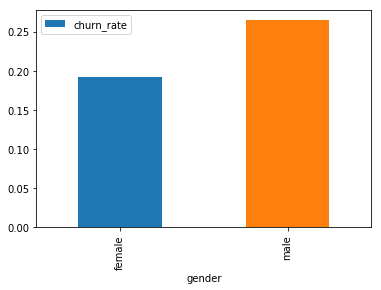

In [119]:
#churn rates of males and females.
df_gender.plot.bar(x="gender", y="churn_rate")
#df.plot.bar(x='lab', y='val', rot=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f93764bc5f8>]], dtype=object)

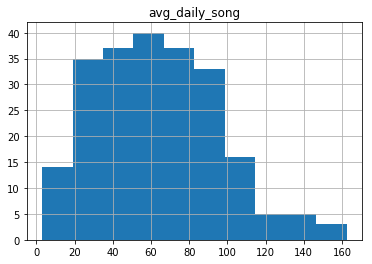

In [157]:
# distribution of average number of song listened per day 
user_log_model_df.hist(column=["avg_daily_song"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9372f8eb38>]], dtype=object)

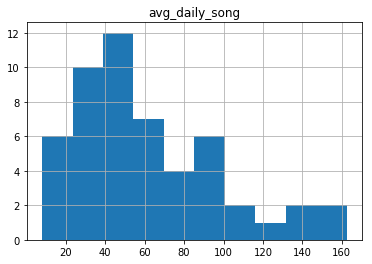

In [174]:
# avg daily song of churners
user_log_model_df.loc[user_log_model_df["Churn"]==1].hist(column=["avg_daily_song"])

In [176]:
import seaborn as sns

In [179]:
user_log_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 16 columns):
userId                          225 non-null object
is_male                         225 non-null int32
count_distinct_day              225 non-null int64
avg_daily_song                  225 non-null float64
avg_daily_distinct_artist       225 non-null float64
avg_daily_distinct_song         225 non-null float64
avg_error_per_session           225 non-null float64
avg_thumbs_up_per_song          225 non-null float64
avg_thumbs_down_per_song        225 non-null float64
avg_add_to_playlist_per_song    225 non-null float64
Churn                           225 non-null int64
avg_daily_login                 225 non-null float64
avg_daily_mls                   225 non-null float64
avg_daily_mla                   225 non-null float64
avg_daily_upgrade               225 non-null float64
avg_daily_downgrade             225 non-null float64
dtypes: float64(12), int32(1), int64(2), object(1)
mem

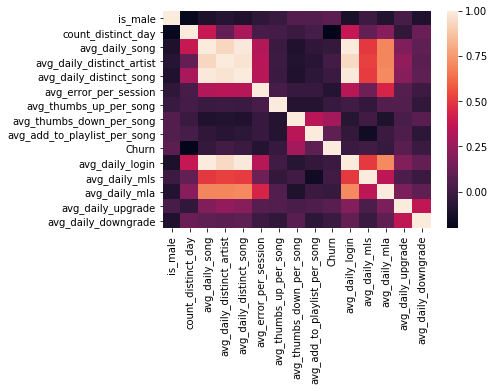

In [201]:
# the correlation heatmap of features
sns.heatmap(user_log_model_df.drop(axis=1, columns=["userId"]).corr(),)

In [223]:
#correlation matrix of features
user_log_model_df.drop(axis=1, columns=["userId"]).corr()

,is_male,count_distinct_day,avg_daily_song,avg_daily_distinct_artist,avg_daily_distinct_song,avg_error_per_session,avg_thumbs_up_per_song,avg_thumbs_down_per_song,avg_add_to_playlist_per_song,Churn,avg_daily_login,avg_daily_mls,avg_daily_mla,avg_daily_upgrade,avg_daily_downgrade
is_male,1.000000,-0.175088,-0.109925,-0.082143,-0.100566,-0.052795,-0.019833,0.058324,0.053275,0.085340,-0.113692,-0.009036,-0.090222,0.025734,-0.099705
count_distinct_day,-0.175088,1.000000,0.387916,0.103935,0.296809,0.026031,0.015876,-0.013893,0.021697,-0.201330,0.380313,0.107264,0.208162,-0.046295,0.123860
avg_daily_song,-0.109925,0.387916,1.000000,0.938745,0.992862,0.327601,-0.016492,-0.102238,-0.048415,-0.032635,0.997538,0.500800,0.698983,0.185708,0.092204
avg_daily_distinct_artist,-0.082143,0.103935,0.938745,1.000000,0.972076,0.343086,-0.007760,-0.089466,-0.072098,0.012761,0.941202,0.521037,0.697249,0.237598,0.084315
avg_daily_distinct_song,-0.100566,0.296809,0.992862,0.972076,1.000000,0.339807,-0.015814,-0.099372,-0.056134,-0.017212,0.991601,0.511066,0.707812,0.207082,0.091519
avg_error_per_session,-0.052795,0.026031,0.327601,0.343086,0.339807,1.000000,0.024509,-0.025694,-0.024197,-0.085563,0.338381,0.133748,0.437531,0.068698,-0.009833
avg_thumbs_up_per_song,-0.019833,0.015876,-0.016492,-0.007760,-0.015814,0.024509,1.000000,-0.084097,-0.086859,-0.026816,0.001976,-0.039709,0.056201,0.053120,-0.043124
avg_thumbs_down_per_song,0.058324,-0.013893,-0.102238,-0.089466,-0.099372,-0.025694,-0.084097,1.000000,0.347583,0.286773,-0.076039,0.006481,-0.104326,0.029700,0.079530
avg_add_to_playlist_per_song,0.053275,0.021697,-0.048415,-0.072098,-0.056134,-0.024197,-0.086859,0.347583,1.000000,0.090871,-0.039142,-0.148024,-0.014344,0.044175,-0.057863
Churn,0.085340,-0.201330,-0.032635,0.012761,-0.017212,-0.085563,-0.026816,0.286773,0.090871,1.000000,-0.014697,0.000830,-0.027977,0.075370,-0.017579


In [224]:
# churn rate of all users: 23%
churn_rate_of_all_users = user_log_model_df.loc[user_log_model_df["Churn"]==1].shape[0] / user_log_model_df.shape[0]
churn_rate_of_all_users

0.2311111111111111

In [164]:
churn_rate_of_women = user_log_model_df.loc[(user_log_model_df["is_male"]==0) & (user_log_model_df["Churn"]==1)].shape[0] / user_log_model_df.loc[user_log_model_df["is_male"]==0].shape[0]
churn_rate_of_women

0.19230769230769232

In [165]:
churn_rate_of_men = user_log_model_df.loc[(user_log_model_df["is_male"]==1) & (user_log_model_df["Churn"]==1)].shape[0] / user_log_model_df.loc[user_log_model_df["is_male"]==1].shape[0]
churn_rate_of_men

0.2644628099173554

In [ ]:
x = np.random.rand(120)
df = pd.DataFrame({"x":x})

bins= [0,0.35,0.7,1]
plt.hist(df.values, bins=bins, edgecolor="k")
plt.xticks(bins)

plt.show()

In [ ]:
df = df.groupby(['category']).filter(lambda x: len(x) >= 5)

group = df.groupby(['category'])['active_seconds'].sum().reset_index(name='count_sec_target')
print (group)
      category  count_sec_target
0  Automobiles               233
1    Computers                47

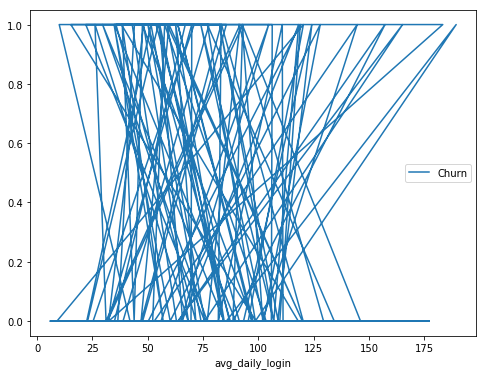

In [225]:
# when avg daily login count increases the churn (1.0 line at chart) gets sparse.
user_log_model_df.plot.line(x='avg_daily_login', y='Churn', figsize=(8,6))

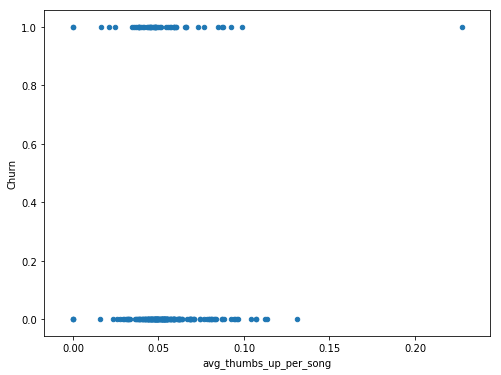

In [226]:
# when avg thumbs up per song >= 0.08 (approximately), the churn rate decreases 
user_log_model_df.plot.scatter(x='avg_thumbs_up_per_song', y='Churn', figsize=(8,6))

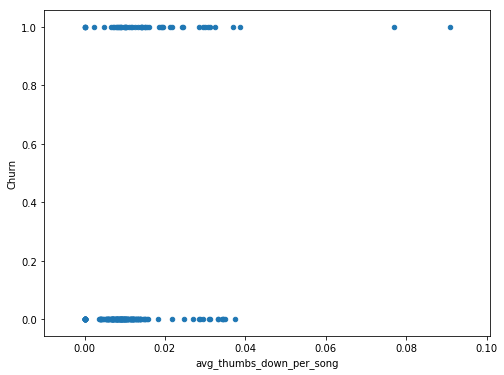

In [227]:
# when avg thumbs down per song >= 0.02 (approximately), the churn rate increases 
user_log_model_df.plot.scatter(x='avg_thumbs_down_per_song', y='Churn', figsize=(8,6))

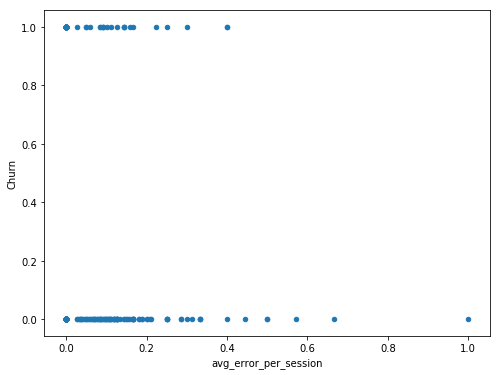

In [228]:
# the increment at avg_error_per_session, increases churn rate.
user_log_model_df.plot.scatter(x='avg_error_per_session', y='Churn', figsize=(8,6))

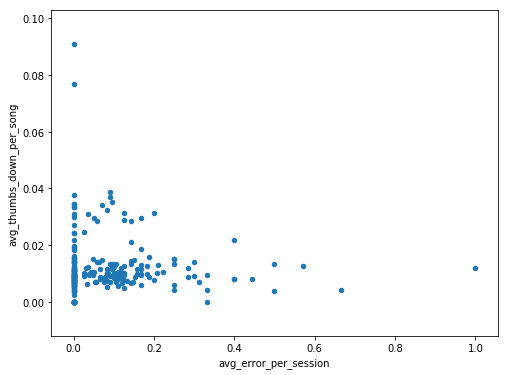

In [229]:
# it shows that taking error does not cause thumbs down.
user_log_model_df.plot.scatter(x='avg_error_per_session', y='avg_thumbs_down_per_song', figsize=(8,6))

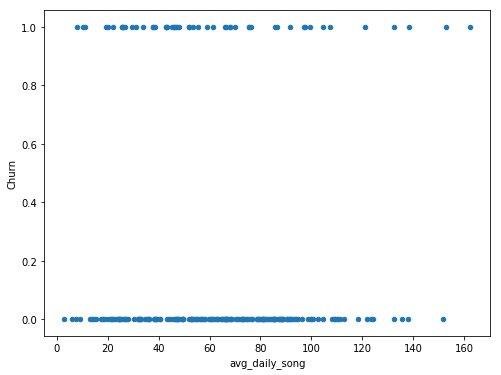

In [230]:
# users with higher listeners are less tend to churn.
user_log_model_df.plot.scatter(x='avg_daily_song', y='Churn', figsize=(8,6))

In [231]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hourr).count().orderBy(user_log.hourr.cast("float"))

In [232]:
songs_in_hour.show(25)

+-----+-----+
|hourr|count|
+-----+-----+
|    0| 9062|
|    1| 8388|
|    2| 8336|
|    3| 8355|
|    4| 8147|
|    5| 8178|
|    6| 8054|
|    7| 8091|
|    8| 8253|
|    9| 8498|
|   10| 8882|
|   11| 8830|
|   12| 9326|
|   13| 9644|
|   14|10494|
|   15|11354|
|   16|11636|
|   17|11460|
|   18|11124|
|   19|10930|
|   20|10856|
|   21|10458|
|   22|10122|
|   23| 9630|
+-----+-----+



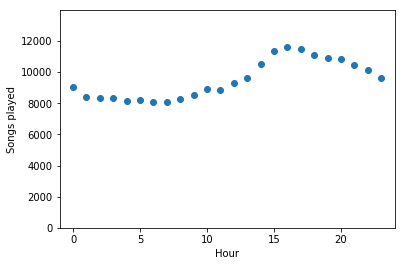

In [233]:
# song counts per hour
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hourr = pd.to_numeric(songs_in_hour_pd.hourr)

plt.scatter(songs_in_hour_pd["hourr"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [123]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, StandardScaler 
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics, MultilabelMetrics

import re

In [125]:
# creating train_cols and target_col(label)
train_cols = [el for el in columns if el not in ("userId", "Churn")]
target_col = "Churn"
print(train_cols)
print("-----------")
print(target_col)

['is_male', 'count_distinct_day', 'avg_daily_song', 'avg_daily_distinct_artist', 'avg_daily_distinct_song', 'avg_error_per_session', 'avg_thumbs_up_per_song', 'avg_thumbs_down_per_song', 'avg_add_to_playlist_per_song', 'avg_daily_login', 'avg_daily_mls', 'avg_daily_mla', 'avg_daily_upgrade', 'avg_daily_downgrade']
-----------
Churn


## Transformation Pipeline

In [129]:
def generate_preprocessor(user_log_model, train_cols):
    '''
    pipeline for data transformation.
    user_log_model: the dataframe
    train_cols: the columns for training data
    '''
    # vectorization
    assembler = VectorAssembler(inputCols=train_cols, outputCol="_features")
    
    # Standardize Features
    scaler = StandardScaler(inputCol="_features", 
                            outputCol='features', 
                            withStd=True, withMean=False)

    preprocessor = Pipeline(stages = [assembler, scaler]).fit(user_log_model)

    return preprocessor

In [202]:
# creating preprocessed data
preprocessor = generate_preprocessor(user_log_model, train_cols)   
user_log_model_transformed = preprocessor.transform(user_log_model) 
user_log_model_transformed = user_log_model_transformed.select(col("Churn").alias("label"), col("features"))

In [210]:
#train_data, test_data = user_log_model_transformed.randomSplit([0.8, 0.2], seed=42)
train_data, rest_data = user_log_model_transformed.randomSplit([0.6, 0.4], seed=42)
test_data, validation_data = rest_data.randomSplit([0.5, 0.5], seed=42)

## Defining Algrithms, Fitting & Predicting

In [132]:
#defining classification algorithms (logistic reg, randomforest, gradientboostingtree)
lgr =  LogisticRegression(maxIter=5, regParam=0.0, elasticNetParam=0)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [220]:
def fit_predict_the_algorithm(algorithm, train_data, test_data):
    model = algorithm.fit(train_data)
    predictions = model.transform(test_data)
    #evaluator = MulticlassClassificationEvaluator(
    #                labelCol="label", predictionCol="prediction", metricName="f1")
    evaluator = MulticlassClassificationEvaluator()
    #f1_score = evaluator.evaluate(predictions)
    f1_score1 = evaluator.evaluate(predictions,{evaluator.metricName: "f1"})
    accuracy1 = evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

    #print("f1 score: ", f1_score)
    print("f1 score1: ", f1_score1)
    print("accuracy1: ", accuracy1)
    
    return predictions

In [221]:
predictions_lgr = fit_predict_the_algorithm(lgr, train_data, test_data)

f1 score1:  0.5838509316770186
accuracy1:  0.6666666666666666


In [212]:
predictions_rf = fit_predict_the_algorithm(rf, train_data, test_data)

f1 score1:  0.44999999999999996
accuracy1:  0.6


In [213]:
predictions_gbt = fit_predict_the_algorithm(gbt, train_data, test_data)

f1 score1:  0.34285714285714286
accuracy1:  0.4


## Model Tuning

In [147]:
def apply_cross_val(algorithm, user_log_model_transformed, train_data, validation_data):
    evaluator = MulticlassClassificationEvaluator()
    crossval = CrossValidator(estimator=algorithm,
                          #estimatorParamMaps=paramGrid,
                          estimatorParamMaps= ParamGridBuilder() \
                                                .addGrid(lgr.regParam,[0.0, 0.1]) \
                                                .build(),
                          evaluator=evaluator,
                          numFolds=3)
    model = crossval.fit(user_log_model_transformed)
    model.avgMetrics
    predictions = model.transform(validation_data)
    #f1_score = evaluator.evaluate(predictions)
    f1_score1 = evaluator.evaluate(predictions,{evaluator.metricName: "f1"})
    accuracy1 = evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

    print("f1 score1: ", f1_score1)
    print("accuracy1: ", accuracy1)
    print("---------")
    print("predicted: ", predictions.filter(predictions.label == predictions.prediction).count())
    print("total prediction: ", predictions.count())
    #print("accuracy= ", predictions.filter(predictions.label == predictions.prediction).count()/ predictions.count())
    return model, evaluator

In [217]:
lgr_cv_model, lgr_cv_eval = apply_cross_val(lgr, user_log_model_transformed, train_data, validation_data)

f1 score1:  0.6485207100591717
accuracy1:  0.717948717948718
---------
56
78


In [218]:
rf_cv_model, rf_cv_eval = apply_cross_val(rf, user_log_model_transformed, train_data, validation_data)

f1 score1:  0.8449030644152594
accuracy1:  0.8589743589743589
---------
67
78


In [219]:
gbt_cv_model, gbt_cv_eval = apply_cross_val(gbt, user_log_model_transformed, train_data, validation_data)

f1 score1:  0.9739389920424404
accuracy1:  0.9743589743589743
---------
76
78


### The f1 score of Logistic Regression, Random Forest Classifier and Gradient Boosted Tree Classifier are 0.58, 0.45, 0.34 respectively.
### When we applied cross validation, the result changed a lot; f1 score of Gradient Boosted Tree Classifier became 0,97 which is the highest in them (although GBT was the worst of them before cross validation). So I chose gbt_cv_model.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.